<a href="https://colab.research.google.com/github/sesidhar-7/final_proj/blob/main/VIT_HHO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install vit-keras
!pip install tensorflow-addons
!pip install tensorflow==2.12.0
!pip install tensorflow-addons==0.20.0
!pip install vit-keras==0.1.1


  Using cached tensorflow_addons-0.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.8 kB)
Using cached tensorflow_addons-0.20.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (591 kB)
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow_addons.metrics import F1Score
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
import kagglehub


/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
import kagglehub


In [4]:
TARGET_SIZE = (128, 128)
BATCH_SIZE = 16
LR = 0.0001
EPOCHS = 1  # Increased for better metrics visualization
FINE_TUNING_EPOCHS = 2
TOTAL_EPOCHS = EPOCHS + FINE_TUNING_EPOCHS

# Download dataset
ROOT_DIRECTORY = kagglehub.dataset_download("sabari50312/fundus-pytorch")
print("Path to dataset files:", ROOT_DIRECTORY)


100%|██████████| 3.82G/3.82G [00:38<00:00, 107MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sabari50312/fundus-pytorch/versions/1


In [5]:
def read_dataset(path):
    datagen = ImageDataGenerator(rescale=1./255)
    train_dataset = datagen.flow_from_directory(
        os.path.join(path, "train"),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    test_dataset = datagen.flow_from_directory(
        os.path.join(path, "test"),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    val_dataset = datagen.flow_from_directory(
        os.path.join(path, "val"),
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary'
    )
    return train_dataset, test_dataset, val_dataset

train_dataset, test_dataset, val_dataset = read_dataset(ROOT_DIRECTORY)


Found 8621 images belonging to 2 classes.
Found 2874 images belonging to 2 classes.
Found 5747 images belonging to 2 classes.


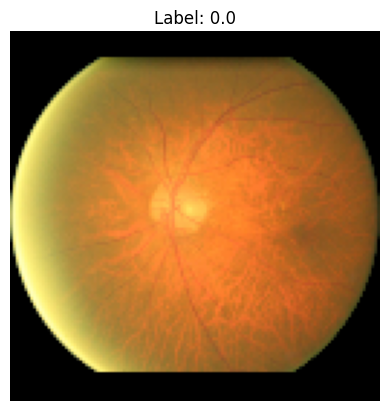

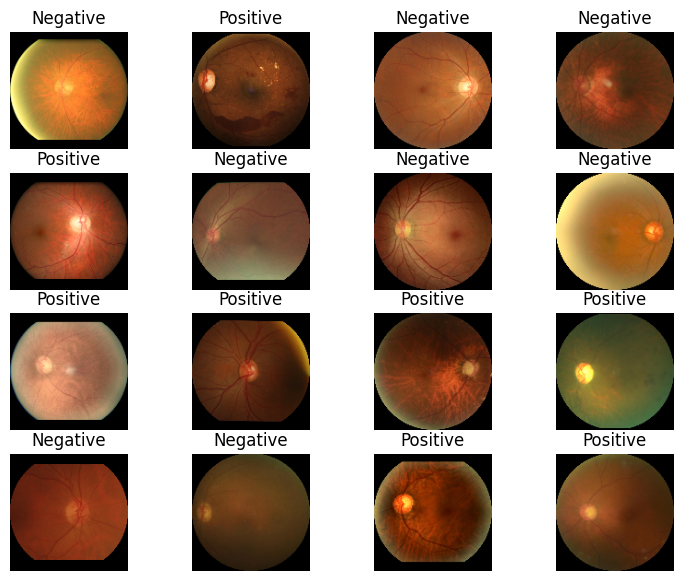

In [6]:
images, labels = next(train_dataset)
plt.imshow(images[0])
plt.title("Label: " + str(labels[0]))
plt.axis('off')
plt.show()

n_cols = 4
n_rows = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(9, 7))
for i in range(n_rows):
    for j in range(n_cols):
        ax[i][j].imshow(images[i * n_cols + j])
        ax[i][j].set_title("Positive" if labels[i * n_cols + j] == 1.0 else "Negative")
        ax[i][j].axis("off")
plt.show()


In [7]:
class HHOOptimizer:
    def __init__(self, model, train_dataset, val_dataset, learning_rate=LR, epochs=EPOCHS):
        self.model = model
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.history = None

    def optimize(self):
        best_model = None
        best_val_loss = float('inf')
        self.history = []

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")
            history = self.model.fit(
                self.train_dataset,
                validation_data=self.val_dataset,
                epochs=1,
                verbose=1
            )
            val_loss = history.history['val_loss'][-1]
            self.history.append(history.history)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = tf.keras.models.clone_model(self.model)
                best_model.set_weights(self.model.get_weights())

        return best_model


In [8]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    print("Building ViT-HHO model...\n")
    base_model = vit.vit_b16(
        image_size=128,
        activation='sigmoid',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=2
    )

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(32, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    metrics = [
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn'),
        tf.keras.metrics.BinaryAccuracy(name='acc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision'),
        F1Score(num_classes=1, threshold=0.5, average='micro', name='F1')
    ]

    print("Compiling model...\n")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )


Building ViT-HHO model...

347502902/347502902 [==============================] - 3s 0us/step


/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 8, 8
  warnings.warn(


Compiling model...



In [9]:
hho_optimizer = HHOOptimizer(model, train_dataset, val_dataset, learning_rate=LR, epochs=EPOCHS)
optimized_model = hho_optimizer.optimize()


Epoch 1/1
539/539 [==============================] - 9108s 17s/step - loss: 0.4676 - tp: 2110.0000 - tn: 4650.0000 - fp: 643.0000 - fn: 1218.0000 - acc: 0.7841 - recall: 0.6340 - precision: 0.7664 - F1: 0.6940 - val_loss: 0.3210 - val_tp: 1798.0000 - val_tn: 3136.0000 - val_fp: 403.0000 - val_fn: 410.0000 - val_acc: 0.8585 - val_recall: 0.8143 - val_precision: 0.8169 - val_F1: 0.8156


In [12]:
# Compile the optimized model
if optimized_model:
    optimized_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='acc'),
            tf.keras.metrics.Recall(name='r'),
            tf.keras.metrics.Precision(name='p'),
            F1Score(num_classes=1, threshold=0.5, average='micro', name='F1')
        ]
    )

# Evaluate the model
results = optimized_model.evaluate(test_dataset, verbose=1)
print("Test Results:", results)


180/180 [==============================] - 775s 4s/step - loss: 0.3278 - tp: 918.0000 - tn: 1542.0000 - fp: 212.0000 - fn: 202.0000 - acc: 0.8559 - r: 0.8196 - p: 0.8124 - F1: 0.8160
Test Results: [0.32775524258613586, 918.0, 1542.0, 212.0, 202.0, 0.855949878692627, 0.8196428418159485, 0.8123893737792969, 0.8159999847412109]


In [26]:

# Display evaluation results
print("Evaluation Results:")
for metric, value in zip(optimized_model.metrics_names, results):
    print(f"{metric}: {value}")



Evaluation Results:
loss: 0.32775524258613586
tp: 918.0
tn: 1542.0
fp: 212.0
fn: 202.0
acc: 0.855949878692627
r: 0.8196428418159485
p: 0.8123893737792969
F1: 0.8159999847412109
